# **Water Cloud Model calibration for soybean**
Input: Sentinel-1 VV-VH backscatter intensities (extracted by points using: GEE)

Input: Load modified excel sheet with backscatter intensities and in-situ data pairs

Output: LUT for a specific channel VV or VH

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Uploaded soybean_calibration.xlsx in google drive and copy the id
# Example: https://drive.google.com/file/d/1ZOa0DYqRiXpKKKXwGIIizioI6xr7qi43/view?usp=sharing
file_id = '1ZOa0DYqRiXpKKKXwGIIizioI6xr7qi43'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
# Download the file to a local disk as 'soybean_calibration.xlsx'.
downloaded.GetContentFile('soybean_calibration.xlsx')

In [ ]:
# Here it is --
!ls -lha soybean_calibration.xlsx

-rw-r--r-- 1 root root 12K Dec 13 14:34 soybean_calibration.xlsx


In [ ]:
# Now, we can use pandas read_excel after installing the excel importer.
!pip install -q xlrd

import pandas as pd
df = pd.read_excel('soybean_calibration.xlsx')
df

,PAI,BIOM,HT,SM,INC,VV,VH
0,0.12,0.019,8,0.321667,30,0.087305,0.018769
1,0.11,0.027,10,0.248667,30,0.216987,0.020001
2,0.15,1.765,10,0.275333,30,0.177233,0.011756
3,0.63,0.069,7,0.331333,30,0.116940,0.013464
4,0.28,0.086,14,0.374000,30,0.112994,0.012839
5,0.53,0.054,12,0.350000,30,0.127886,0.014930
6,0.12,0.020,8,0.397667,30,0.145587,0.017075
7,0.12,0.040,10,0.354000,30,0.141117,0.017261
8,0.36,1.803,13,0.261667,30,0.075922,0.017836
9,0.26,1.628,12,0.301000,30,0.135723,0.013685


In [ ]:
# import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
from scipy.optimize import differential_evolution

In [ ]:
#Pandas dataframe to matrix conversion
Y=df.values;

#Incidence angle
th=30;
thr=th*3.1415/180;
y=Y[:,5]; ## Backscatter VV
x1=Y[:,0]; ## PAI
x2=Y[:,3]; ## Soil moisture

#------------------------------------------------------------------------------
## Linear scale function-WCM
def fitFunc(X,a,b,c,d,e):
    x1,x2=X
    return (a*(np.power(x1,e))*np.cos(thr)*(1-np.exp((-2)*b*np.power((x1),1)/np.cos(thr))))+((d*np.exp(c*x2))*np.cos(thr)*np.exp((-2)*b*np.power((x1),1)/np.cos(thr)))

##-----------------------------------------------------------------------------
##-----------------------------------------------------------------------------
## function for genetic algorithm to minimize (RMSE error)
## bounds on parameters are set in generate_Initial_Parameters() below
## genetic algorithm for initial parameter estimation.
def Error(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    return np.sqrt(np.sum((y - fitFunc((x1,x2), *parameterTuple)) ** 2).mean())


def generate_Initial_Parameters():
    ## min and max used for bounds
    parameterBounds = []
    parameterBounds.append([0,1.1]) # parameter bounds for a
    parameterBounds.append([0,0.5]) # parameter bounds for b
    parameterBounds.append([-0.5,1]) # parameter bounds for c
    parameterBounds.append([-0.5,1]) # parameter bounds for d
    parameterBounds.append([-1.5,1]) # parameter bounds for e
    ##parameterBounds.append([-100,100]) # parameter bounds for f
   

    ## "seed" the numpy random number generator for repeatable results
    ##https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html
    result = differential_evolution(Error, parameterBounds, strategy='best1bin',polish=True,seed=3,init='latinhypercube')
    return result.x

## generate initial parameter values
initialParameters = generate_Initial_Parameters()

##-----------------------------------------------------------------------------
## OR directly define initial parameters
#initialParameters=[0.2,1.357,2,4,-1.965]

##-----------------------------------------------------------------------------
##-----------------------------------------------------------------------------
# curve fit the test data
fitParams,fitCovariances = curve_fit(fitFunc,(x1,x2),y, initialParameters,method='lm',maxfev=6000,ftol=1e-8)
#fitParams

In [ ]:
##-----------------------------------------------------------------------------
#predicting with fitted function
A = (x1,x2)
ypred=fitFunc(A,fitParams[0],fitParams[1],fitParams[2],fitParams[3],fitParams[4])
#ypred

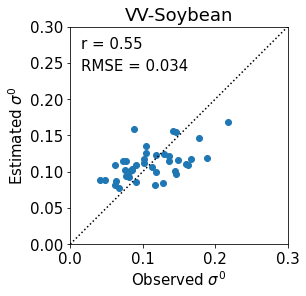

Fitted WCM coefficients for VV =
 [ 2.62249881  0.11949044  0.09427497 -0.69313384 -1.09693014]


In [ ]:
#rmse estimation
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(ypred, y)
#print('RMSE=',rmse_val)

#Correlation coefficient 
corrr=np.corrcoef(ypred,y)
rr= corrr[0,1]
#print('r=',rr)
#
##---------------------------------------------------------------
## Plotting calibration points
plt.scatter(y,ypred)
plt.xlim([0, 0.3])
plt.ylim([0, 0.3])
plt.xlabel("Observed $\sigma^0$")
plt.ylabel("Estimated $\sigma^0$")
plt.title("VV-Soybean")
plt.plot([0, 0.3], [0, 0.3], 'k:')
plt.annotate('r = %.2f'%rr, xy=(0.015,0.27)) #round off upto 3decimals
plt.annotate('RMSE = %.3f'%rmse_val, xy=(0.015,0.24))
matplotlib.rcParams.update({'font.size': 15})
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
#plt.savefig('VV_Soybean.png')

print('Fitted WCM coefficients for VV =\n',fitParams)

In [ ]:
LUT = np.vstack((x1, x2, ypred))
LUT_soybean = LUT.T
#LUT.shape
df2 = pd.DataFrame(LUT_soybean, columns = ['PAI','SM','VV'])
print(df2)

     PAI        SM        VV
0   0.12  0.321667  0.158512
1   0.11  0.248667  0.168435
2   0.15  0.275333  0.146793
3   0.63  0.331333  0.081129
4   0.28  0.374000  0.106748
5   0.53  0.350000  0.084059
6   0.12  0.397667  0.154207
7   0.12  0.354000  0.156684
8   0.36  0.261667  0.101623
9   0.26  0.301000  0.114327
10  1.50  0.234333  0.087750
11  2.48  0.338000  0.103012
12  1.83  0.401000  0.087841
13  3.36  0.419333  0.116135
14  4.03  0.357333  0.126246
15  5.29  0.378667  0.135951
16  0.49  0.212667  0.093192
17  2.85  0.241333  0.112365
18  1.83  0.420000  0.087167
19  3.12  0.343667  0.114192
20  2.96  0.424667  0.109449
21  0.90  0.337333  0.077263
22  1.90  0.278667  0.093519
23  1.34  0.327000  0.081543
24  2.69  0.234333  0.109813
25  2.43  0.321333  0.102547
26  3.40  0.363000  0.118034
27  3.67  0.358667  0.121871
28  0.95  0.151667  0.085557
29  3.33  0.114000  0.122745
30  2.34  0.475000  0.096070
31  3.72  0.286333  0.124030
32  2.35  0.316000  0.101161
33  2.37  0.31

***Exporting the LUT to Google Drive***

First Create a directory named 'EarthEngine' in your google drive manualy

Then run the follwing snippet

In [ ]:
from google.colab import  drive
drive.mount('/drive')
df2.to_csv('/drive/My Drive/EarthEngine/SoybeanLUT.csv')
#df2.to_excel('/drive/My Drive/EarthEngine/SoybeanLUT.xlsx')
drive.flush_and_unmount()

Mounted at /drive
